In [1]:
import ase.io as aio
from ase.units import Bohr
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

import numpy as np
from pyscf import gto, dft
from pyscf.geomopt.geometric_solver import optimize

from matplotlib import pyplot as plt

/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
import glob
# total energy of relaxed fragments
energies_frags = dict()

for row in ['row_2', 'row_3', 'row_4']:
    system = 'fragments'
    bond_type = 'single'

    efiles = glob.glob(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/{system}_{bond_type}/*_energy_relaxed')
    for file in efiles:
        with open(file, 'r') as f:
            smiles = file.split('/')[-1].split('_')[0]
            frags = uqm.fragmentize_smiles(smiles)
            frag_name = frags[0]
    #         if len(re.findall(r"\[.*?\]", smiles)) > 0:
    #             frag_name = re.findall(r"\[.*?\]", smiles)[0]
    #         else:
    #             frag_name = re.sub( r"([A-Z])", r" \1", smiles).split()[0]

            energies_frags[frag_name] = float(f.readline().strip('\n'))

In [3]:
# set parameters
comps = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']

energies = dict()
for c in comps:
    row = 'row_2'
    system = 'diatomics'
    bond_type = 'single'
    spin = 0

    # optimize intial geometry
    atoms_eq = aio.read(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/{row}/{system}_{bond_type}/{c}_opt.xyz')

    # change distance between A and B and calculate energy
    dz = np.linspace(-0.3, 0.5, 9)
    energy_tot = []
    energy_el = []
    energy_nuc = []
    dist = []
    for d in dz:
        atoms_dz = atoms_eq.copy()

        # number of H atoms attached to first heavy atom, necessary to get indices of atoms that will be moved
        hA = uqm.hcount_smiles(c)[0] # H-atoms bonded to first heavy atom
        indices = [1]+list(np.arange(5, atoms_eq.get_number_of_atoms())) # indices of second heavy atom and its hydrogens, will be moved

        atoms_dz.set_distance(0, 1, d, fix=0, add = True, indices=indices)

        dist.append(atoms_dz.get_distance(0,1))

        pyscf_atoms = uqm.ase2pyscf(atoms_dz)
        basis = 'def2-tzvp'
        mol = gto.Mole()
        mol.atom = pyscf_atoms
        mol.basis = basis
        mol.spin = spin
        mol.build()

        if spin != 0:
            mf = dft.ROKS(mol)
        else:
            mf = dft.RKS(mol)
        mf.xc = 'pbe0'
        mf.kernel()
        energy_tot.append(mf.e_tot)
        energy_el.append(mf.e_tot-mol.energy_nuc())
        energy_nuc.append(mol.energy_nuc())
    
    
    f1, f2 = uqm.fragmentize_smiles(c)
    eb = np.array(energy_tot) - energies_frags[f1] - energies_frags[f2]
    energies[c] = [energy_tot, energy_el, energy_nuc, eb, dist]


/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/ase/atoms.py:967: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


converged SCF energy = -79.6662364664936
converged SCF energy = -79.719502039756
converged SCF energy = -79.7438160034301
converged SCF energy = -79.7502038166714
converged SCF energy = -79.7456471986707
converged SCF energy = -79.7346053271396
converged SCF energy = -79.7199381758996
converged SCF energy = -79.7034785804557
converged SCF energy = -79.6863937513555
converged SCF energy = -95.6755449714139
converged SCF energy = -95.7406236533207
converged SCF energy = -95.7697653777943
converged SCF energy = -95.7772908820019
converged SCF energy = -95.7720374403682
converged SCF energy = -95.7595009512676
converged SCF energy = -95.7431127241685
converged SCF energy = -95.7250176439716
converged SCF energy = -95.7065499740321
converged SCF energy = -115.525529701331
converged SCF energy = -115.597543766952
converged SCF energy = -115.6292046576
converged SCF energy = -115.637261842517
converged SCF energy = -115.631727106237
converged SCF energy = -115.618650096008
converged SCF energ

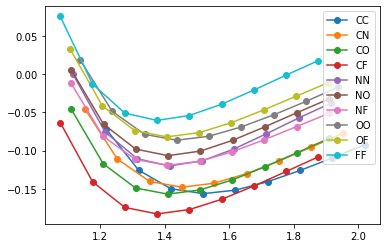

In [4]:
for k in energies.keys():
    plt.plot(energies[k][-1], energies[k][-2], '-o', label = k)
    plt.legend()

In [5]:
eb = []
for k in energies.keys():
    eb.append(np.amin(energies[k][-2]))

In [7]:
el2Z = {'C':6, 'N':7, 'O':8, 'F':9}
Z2el = {6:'C', 7:'N', 8:'O', 9:'F'}

ZA = []
ZB = []
for k in energies.keys():
    fA, fB = uqm.fragmentize_smiles(k)
    ZA.append(el2Z[fA])
    ZB.append(el2Z[fB])

In [8]:
eb_mat = np.zeros((4,4))
for ii, i in enumerate(range(6, 10)):
    for ij, j in enumerate(range(6, 10)):
        if i <= j:
            smiles = Z2el[i] + Z2el[j]
        else:
            smiles = Z2el[j] + Z2el[i]
        eb_mat[ii, ij] = np.amin(energies[smiles][-2])

In [9]:
eb_mat

array([[-0.15634173, -0.14794698, -0.15701121, -0.18287994],
       [-0.14794698, -0.12009637, -0.10668197, -0.11928164],
       [-0.15701121, -0.10668197, -0.0864671 , -0.0821001 ],
       [-0.18287994, -0.11928164, -0.0821001 , -0.06053666]])

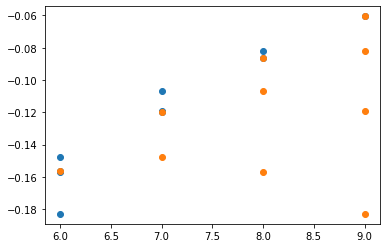

In [10]:
plt.plot(ZA, eb, 'o')
plt.plot(ZB, eb, 'o')

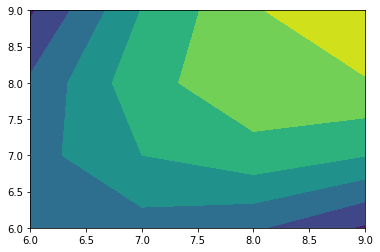

In [11]:
plt.contourf(np.arange(6, 10), np.arange(6, 10), eb_mat)

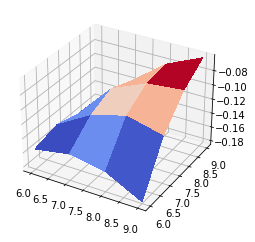

In [22]:
X = np.arange(6, 10)
X, Y = np.meshgrid(X, X)
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


# Plot the surface.
surf = ax.plot_surface(X, Y, eb_mat, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# ax.plot_surface(X, Y, eb_mat)

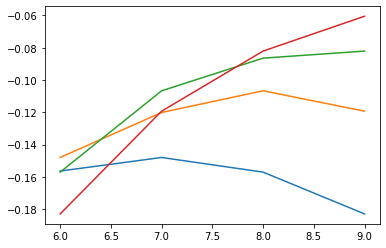

In [16]:
plt.plot(np.arange(6, 10), eb_mat[0])
plt.plot(np.arange(6, 10), eb_mat[1])
plt.plot(np.arange(6, 10), eb_mat[2])
plt.plot(np.arange(6, 10), eb_mat[3])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [19]:
from ase import Atoms
from ase.visualize import view
import leruli

In [22]:
out = leruli.graph_to_geometry('CN', 'XYZ')
geo = out['geometry'].split('\n')[2:-1]
elements = []
coords = []
for g in geo:
    elements.append(g.split()[0])
    coords_tmp = []
    for c in g.split()[1:]:
        coords_tmp.append(float(c))
    coords.append(coords_tmp)
# out

In [23]:
ethane = Atoms(symbols=elements, positions=coords)
view(ethane)

<Popen: returncode: None args: ['/home/sahre/opt/miniconda3/envs/qm-tools/bi...>

In [25]:
from pyscf import gto, dft

/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(


(['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
 [[1.24985149590915, -0.02247745751096, -0.28430810429857],
  [0.01289016882808, -0.21697527902362, 0.5841199549363],
  [-1.25946337801259, 0.18441808164718, -0.15215790193093],
  [1.34728538486147, 1.02028868019854, -0.57912940825853],
  [2.14853305847932, -0.31259730794133, 0.25482876680054],
  [1.18041547976625, -0.6264391116977, -1.18603966005047],
  [-0.0575690594184, -1.26468950502261, 0.8845875913037],
  [0.11037918510413, 0.38219414688692, 1.49216844375394],
  [-2.13238058655873, 0.04013138330349, 0.4805426727495],
  [-1.38419996611126, -0.41513918786529, -1.05100912941729],
  [-1.21574178284741, 1.23128555702537, -0.44360322558816]])

In [56]:
import ase.io as aio
from ase.units import Bohr
from ase import Atoms
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

from pyscf import gto, dft, scf

# geometric
from pyscf.geomopt.geometric_solver import optimize

# comps = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']

spin = 0

el, coords = uqm.graph2geometry('CCC')
atoms = Atoms(symbols=el, positions=coords)

# atoms = aio.read('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/diatomics_single/ethrad.xyz')

pyscf_atoms = uqm.ase2pyscf(atoms)
basis = 'def2-tzvp'
mol = gto.Mole()
mol.atom = pyscf_atoms
mol.spin = spin
mol.basis = basis
mol.build()

if spin != 0:
    mf = dft.ROKS(mol)
else:
    mf = dft.RKS(mol)
mf.xc = 'pbe0'

mol_eq = optimize(mf, maxsteps=100)

new_pos = mol_eq.atom_coords()*Bohr
atoms.set_positions(new_pos)

pyscf_atoms = uqm.ase2pyscf(atoms)
basis = 'def2-tzvp'
mol = gto.Mole()
mol.atom = pyscf_atoms
mol.basis = basis
mol.spin = spin
mol.build()

if spin != 0:
    mf = dft.ROKS(mol)
else:
    mf = dft.RKS(mol)
mf.xc = 'pbe0'
mf.kernel()

e = mf.e_tot


/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **          


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C   1.249851  -0.022477  -0.284308    0.000000  0.000000  0.000000
   C   0.012890  -0.216975   0.584120    0.000000  0.000000  0.000000
   C  -1.259463   0.184418  -0.152158    0.000000  0.000000  0.000000
   H   1.347285   1.020289  -0.579129    0.000000  0.000000  0.000000
   H   2.148533  -0.312597   0.254829    0.000000  0.000000  0.000000
   H   1.180415  -0.626439  -1.186040    0.000000  0.000000  0.000000
   H  -0.057569  -1.264690   0.884588    0.000000  0.000000  0.000000
   H   0.110379   0.382194   1.492168    0.000000  0.000000  0.000000
   H  -2.132381   0.040131   0.480543    0.000000  0.000000 -0.000000
   H  -1.384200  -0.415139  -1.051009    0.000000  0.000000  0.000000
   H  -1.215742   1.231286  -0.443603    0.000000  0.000000  0.000000
converged SCF energy = -119.028203088341
--------------- SCF_Scanner gradients ---------------
       

Step    0 : Gradient = 5.346e-03/8.603e-03 (rms/max) Energy = -119.0282030883
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 5.00000e-02 ... 3.50963e-01 3.51002e-01 3.51133e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C   1.256420  -0.024408  -0.280445    0.006568 -0.001930  0.003863
   C   0.012775  -0.215038   0.579158   -0.000115  0.001938 -0.004962
   C  -1.265751   0.183500  -0.147667   -0.006288 -0.000918  0.004491
   H   1.363976   1.020935  -0.581914    0.016691  0.000646 -0.002785
   H   2.163855  -0.313862   0.254665    0.015322 -0.001265 -0.000164
   H   1.196601  -0.628004  -1.189988    0.016186 -0.001565 -0.003948
   H  -0.057225  -1.262386   0.888955    0.000344  0.002304  0.004368
   H   0.109813   0.377594   1.494133   -0.000566 -0.004600  0.001964
   H  -2.147446   0.041275   0.481624   -0.015066  0.001144  0.001081
   H  -1.400464  -0.413908  -1.053262   -0.016264  0.001231 -0.002253
   H  -1.232166   1.234990  -0.444967   -0.016425  0.003704 -0.001364

WARN: Large deviations found between the input molecule and the molecule from chkfile
Initial guess d

Step    1 : Displace = 1.275e-02/1.695e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 1.698e-03/3.502e-03 (rms/max) E (change) = -119.0285168011 (-3.137e-04) Quality = 1.133
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 4.99969e-02 ... 3.50977e-01 3.50990e-01 3.86375e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C   1.254591  -0.024506  -0.279266   -0.001828 -0.000098  0.001179
   C   0.012706  -0.214002   0.576711   -0.000069  0.001035 -0.002447
   C  -1.263816   0.183135  -0.146871    0.001935 -0.000365  0.000796
   H   1.366707   1.020602  -0.583298    0.002731 -0.000333 -0.001384
   H   2.162317  -0.314132   0.256045   -0.001537 -0.000270  0.001380
   H   1.199296  -0.627067  -1.190970    0.002695  0.000937 -0.000982
   H  -0.057028  -1.260592   0.891552    0.000197  0.001794  0.002596
   H   0.109515   0.374628   1.495118   -0.000299 -0.002966  0.000985
   H  -2.145890   0.040889   0.482486    0.001556 -0.000386  0.000862
   H  -1.402928  -0.412372  -1.054247   -0.002464  0.001537 -0.000985
   H  -1.234851   1.235178  -0.446350   -0.002685  0.000189 -0.001382
converged SCF energy = -119.028548804106
--------------- SCF_Scanner gradients ---------------
       

Step    2 : Displace = 2.706e-03/3.147e-03 (rms/max) Trust = 1.414e-01 (+) Grad = 2.937e-04/7.534e-04 (rms/max) E (change) = -119.0285488041 (-3.200e-05) Quality = 1.092
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 4.69747e-02 ... 3.50984e-01 3.51907e-01 3.79429e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C   1.254795  -0.024510  -0.279014    0.000203 -0.000004  0.000252
   C   0.012641  -0.213516   0.575712   -0.000065  0.000486 -0.000999
   C  -1.263966   0.183268  -0.146777   -0.000149  0.000133  0.000094
   H   1.367719   1.020176  -0.583268    0.001012 -0.000426  0.000030
   H   2.162003  -0.314265   0.256608   -0.000315 -0.000133  0.000563
   H   1.200346  -0.626673  -1.190682    0.001050  0.000394  0.000288
   H  -0.057065  -1.259824   0.891829   -0.000037  0.000768  0.000277
   H   0.109362   0.373993   1.494963   -0.000153 -0.000635 -0.000155
   H  -2.145638   0.040911   0.482722    0.000253  0.000022  0.000236
   H  -1.403746  -0.411693  -1.054069   -0.000818  0.000678  0.000177
   H  -1.235736   1.234993  -0.446408   -0.000885 -0.000186 -0.000059
converged SCF energy = -119.028550136606
--------------- SCF_Scanner gradients ---------------
       

Step    3 : Displace = 8.108e-04/1.132e-03 (rms/max) Trust = 2.000e-01 (+) Grad = 5.754e-05/9.769e-05 (rms/max) E (change) = -119.0285501366 (-1.333e-06) Quality = 0.991
Hessian Eigenvalues: 2.29997e-02 2.30000e-02 4.16233e-02 ... 3.50984e-01 3.52457e-01 3.66237e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C   1.254895  -0.024441  -0.278947    0.000100  0.000069  0.000067
   C   0.012592  -0.213359   0.575571   -0.000049  0.000157 -0.000142
   C  -1.264021   0.183465  -0.146873   -0.000056  0.000197 -0.000096
   H   1.367929   1.020215  -0.583111    0.000210  0.000039  0.000156
   H   2.161771  -0.314345   0.257034   -0.000232 -0.000079  0.000426
   H   1.200521  -0.626584  -1.190576    0.000175  0.000089  0.000106
   H  -0.057164  -1.259624   0.891918   -0.000099  0.000201  0.000089
   H   0.109270   0.373910   1.495013   -0.000092 -0.000083  0.000050
   H  -2.145453   0.040995   0.482837    0.000185  0.000084  0.000115
   H  -1.403795  -0.411469  -1.054128   -0.000049  0.000224 -0.000058
   H  -1.235759   1.235165  -0.446415   -0.000022  0.000173 -0.000007
converged SCF energy = -119.028550184399
--------------- SCF_Scanner gradients ---------------
       

Step    4 : Displace = 1.804e-04/3.091e-04 (rms/max) Trust = 2.828e-01 (+) Grad = 1.408e-05/2.968e-05 (rms/max) E (change) = -119.0285501844 (-4.779e-08) Quality = 0.810
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    
Time elapsed since start of run_optimizer: 21.782 seconds


converged SCF energy = -119.028550184403


In [52]:
atoms.get_atomic_numbers()

array([6, 6, 1, 1, 1, 1, 1, 1])

In [57]:
atoms.get_distance(0,1)

1.5196071331148866

In [53]:
ethane_mol = atoms.copy()

In [58]:
atoms.get_distance(0,1) - ethane_mol.get_distance(0,1)

0.0008267672578854413

In [38]:
propane = -119.02855018440404

In [39]:
# ethane
ethane = -79.75020381667164

In [40]:
# ethyl
ethyl = -79.08027122557563

In [41]:
# methly
methyl = -39.796931044615306

In [42]:
propane - ethyl - methyl

-0.15134791421310467

In [43]:
ethane - 2*methyl

-0.15634172744103125

In [13]:
import numpy as np
from matplotlib import pyplot as plt

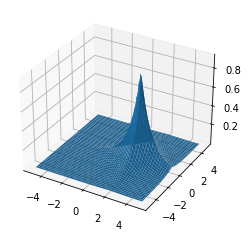

In [34]:
c = np.linspace(-5, 5, 100)
x,y = np.meshgrid(c,c)

s_orbital = lambda x: np.exp(-np.abs(x))
s_orbital2 = lambda y: np.exp(-np.abs(y-2))
wf = s_orbital(y)*s_orbital2(x)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,wf)

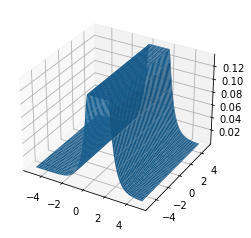

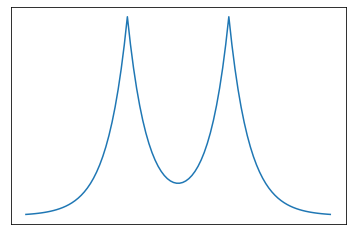

In [41]:
c = np.linspace(-5, 10, 100)
fig = plt.figure(frameon=False)
plt.plot(c, np.exp(-np.abs(c))+np.exp(-np.abs(c-5)))

plt.xticks([])
plt.yticks([])

plt.savefig('/home/sahre/work/bonding_trends/figures/conceptual/orb1s.png')

In [1]:
# binding curve sketch
import numpy as np
from matplotlib import pyplot as plt

([], [])

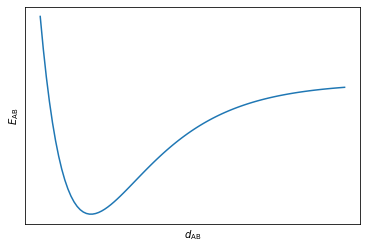

In [12]:
morse = lambda x, x0, De, a: De*(1-np.exp(-a*(x-x0)))**2 

x = np.linspace(0.2, 5, 100)
plt.plot(x, morse(x, 1, 1, 1)-1)
plt.xlabel(r'$d_{\rm{AB}}$')
plt.ylabel(r'$E_{\rm{AB}}$')

plt.xticks([])
plt.yticks([])
